In [1]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import scipy.constants as const
import astropy.constants as aconst
from pycbc import fft
from pycbc.filter import match, overlap_cplx, sigma, sigmasq, make_frequency_series
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.waveform import taper_timeseries
from pycbc.types import timeseries, frequencyseries, zeros, complex_same_precision_as
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


In [2]:
# Load data
with open(os.path.join('harmonic_overlaps_data', 'dataslot_3', 'all_matches'), 'rb') as fp:
    data = pickle.load(fp)

fid_chirp = list(data.keys())[0]
fid_e = list(data[fid_chirp].keys())[0]

# Calculate degeneracy lines
sparse_e_vals = np.linspace(data[fid_chirp][fid_e]['e_vals'][0], data[fid_chirp][fid_e]['e_vals'][-1], 31)
init_guess = fid_chirp
sample_rate = data[fid_chirp][fid_e]['fid_params']['sample_rate']
f_low = data[fid_chirp][fid_e]['fid_params']['f_low']
q = data[fid_chirp][fid_e]['fid_params']['q']
min_func = lambda x: abs(chirp_degeneracy_line(x, fid_e, sample_rate=sample_rate, f_low=f_low, q=q) - fid_chirp)
zero_ecc_chirp_mass = minimize(min_func, init_guess)['x']
sparse_chirp_vals = chirp_degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals, sample_rate=sample_rate, f_low=f_low, q=q)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/t

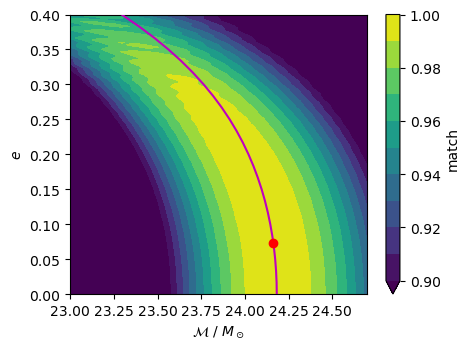

In [20]:
key = 'h0'

# Plot grid
plt.figure(figsize=(0.75*6.4,0.75*4.8))
plt.contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e][key], np.linspace(0.9, 1, 11), vmax=1, vmin=0.9, extend='min')
plt.colorbar(label='match')
plt.scatter(fid_chirp, fid_e, c='r', zorder=5)
xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()

# Plot degeneracy lines
plt.plot(sparse_chirp_vals, sparse_e_vals, c='m', label='full', zorder=3)

# Plot formatting
plt.ylim(ylims[0], 0.4)
plt.xlim(23, xlims[1])
plt.xlabel('$\mathcal{M}~/~M_\odot$')
plt.ylabel('$e$')

plt.tight_layout()
plt.savefig('Figures/ho_standalone.png', dpi=450)

/tmp/ipykernel_965558/2894141589.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


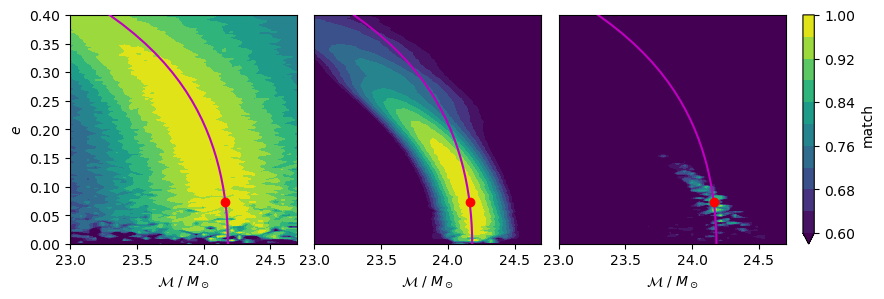

In [22]:
# Plot each grid
keys = ['h-1', 'h1', 'h2']
fig, axs = plt.subplots(ncols=4,figsize=(1.5*6.4, 0.62*4.8), gridspec_kw={'width_ratios':[1,1,1,0.05], 'wspace': 0.1})
for i in range(3):
    key = keys[i]

    # Plot grid
    contours = axs[i].contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e][key], np.linspace(0.6, 1, 11), vmax=1, vmin=0.6, extend='min')
    axs[i].scatter(fid_chirp, fid_e, c='r', zorder=5)
    xlims = axs[i].get_xlim()
    ylims = axs[i].get_ylim()

    # Plot degeneracy lines
    axs[i].plot(sparse_chirp_vals, sparse_e_vals, c='m', label='full', zorder=3)

    # Plot formatting
    axs[i].set_ylim(ylims[0], 0.4)
    axs[i].set_xlim(23, xlims[1])
    axs[i].set_xlabel('$\mathcal{M}~/~M_\odot$')
    axs[i].set_ylabel('$e$')
    if i > 0:
        axs[i].get_yaxis().set_visible(False)
fig.colorbar(contours, cax=axs[-1], label='match')
plt.tight_layout()
plt.savefig('Figures/ho_harms.png', dpi=450, bbox_inches='tight')